In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
epoch_num = 10
lr = 1e-3
batchsize = 32

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batchsize,shuffle=True)

testloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


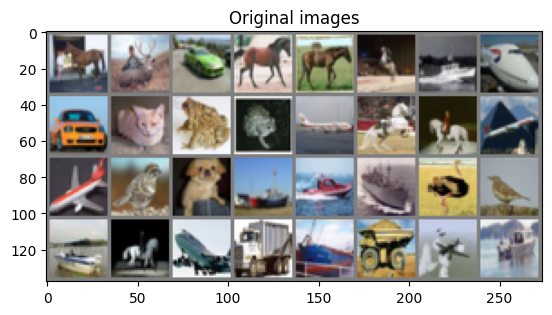

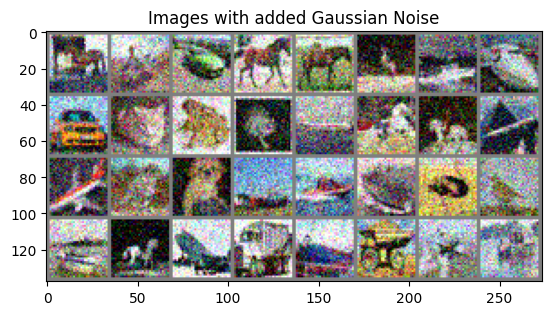

In [ ]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
img, _ = next(iter(trainloader))
noisy_img = img + (0.1**0.5)*torch.randn(img.shape)
noisy_img = torch.clamp(noisy_img, -1, 1)
plt.title("Original images")
imshow(torchvision.utils.make_grid(img))
plt.title("Images with added Gaussian Noise")
imshow(torchvision.utils.make_grid(noisy_img))

In [ ]:
def save_recon_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

def DAE_make_dir():
    image_dir = 'DenoisedAE_Conv_CIFAR10_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)


In [ ]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # encoder
#         self.enc1 = nn.Conv2d(
#             in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=0
#         )
#         self.bn1 = nn.BatchNorm2d(8)
#         self.enc2 = nn.Conv2d(
#             in_channels=8, out_channels=8, kernel_size=3,stride=1, padding=0
#         )
#         self.bn2 = nn.BatchNorm2d(8)
#         # decoder
#         self.dec1 = nn.ConvTranspose2d(
#             in_channels=8, out_channels=8, kernel_size=3,stride=1, padding=0
#         )
#         self.bn3 = nn.BatchNorm2d(8)
#         self.dec2 = nn.ConvTranspose2d(
#             in_channels=8, out_channels=3, kernel_size=3,stride=1, padding=0
#         )
#     def forward(self, x):
#        x = F.relu(self.bn1(self.enc1(x)))
#        x = F.relu(self.bn2(self.enc2(x)))
#        x = F.relu(self.bn3(self.dec1(x)))
#        x = F.relu(self.dec2(x))
#        return x
# model = Autoencoder()
# print(model)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=0),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=1, padding=0),           # [batch, 24, 8, 8]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#
            nn.ConvTranspose2d(8, 8, 3, stride=1, padding=0),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=1, padding=0),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
  )
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=30)


In [ ]:
from torch.types import Device
import numpy as np
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            noisy_img = img + (0.1**0.5)*torch.randn(img.shape)
            # print("Img:", img.min(), img.max())
            noisy_img = torch.clamp(noisy_img, -1, 1)
            # print("Noisy Img:", noisy_img.min(), noisy_img.max())
            img = img.to(device)
            noisy_img = noisy_img.to(device)
            optimizer.zero_grad()
            outputs = net(noisy_img)
            # imshow(torchvision.utils.make_grid(outputs))
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {}'.format(
            epoch+1, epoch_num, loss))
        if epoch % 1 == 0:
            save_recon_image(img.cpu().data, name='./DenoisedAE_Conv_CIFAR10_Images/original{}.png'.format(epoch))
            save_recon_image(outputs.cpu().data, name='./DenoisedAE_Conv_CIFAR10_Images/decoded{}.png'.format(epoch))
    return train_loss


In [ ]:
from skimage import metrics
def test(model, testloader):
     avg_psnr=0
     avg_ssim=0
     testset_size=0
     for idx, batch in enumerate(testloader):
        img, _ = batch
        noisy_img = img + (0.1**0.5)*torch.randn(img.shape)
        noisy_img = torch.clamp(noisy_img, -1, 1)
        img = img.to(device)
        noisy_img = noisy_img.to(device)
        outputs = model(noisy_img)
        batch_avg_psnr=0
        batch_avg_ssim=0
        for i in range(len(img)):
            original=np.transpose(img[i].detach().cpu(), (1, 2, 0)).numpy()
            denoised=np.transpose(outputs[i].detach().cpu(), (1, 2, 0)).numpy()
            original = (original +1)/2
            denoised = (denoised +1)/2
            batch_avg_psnr+=metrics.peak_signal_noise_ratio(original,denoised)
            batch_avg_ssim+=metrics.structural_similarity(original,denoised,multichannel=True)
        avg_psnr+=batch_avg_psnr
        avg_ssim+=batch_avg_ssim
        testset_size+=len(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data

        if idx==1:
          save_image(img,'DAE_original_image.png')
          save_image(noisy_img,'DAE_noisy_image.png')
          save_image(outputs, 'DAE_conv_cifar10_reconstruction.png')
     print("On Test data of {} examples:\nAverage PSNR:{:.3f} \nAverage SSIM: {:.3f}".format(testset_size,avg_psnr/testset_size,avg_ssim/testset_size))


In [ ]:
# from skimage import metrics
# avg_psnr=0
# avg_ssim=0
# testset_size=0

# for idx, batch in enumerate(testloader):
#   img, _ = batch
#   batch_avg_psnr=0
#   batch_avg_ssim=0
#   for i in range(len(img)):
#       original=np.transpose(img[i].detach().cpu(), (1, 2, 0)).numpy()
#       batch_avg_psnr+=metrics.peak_signal_noise_ratio(original,original)
#       batch_avg_ssim+=metrics.structural_similarity(original,original,multichannel=True)
#   avg_psnr+=batch_avg_psnr
#   avg_ssim+=batch_avg_ssim
#   testset_size+=len(img)
# print("On Test data of {} examples:\nAverage PSNR:{:.3f} \nAverage SSIM: {:.3f}".format(testset_size,avg_psnr/testset_size,avg_ssim/testset_size))


cuda:0
Epoch 1 of 10, Train Loss: 0.035313647071177276
Epoch 2 of 10, Train Loss: 0.021936081608451105
Epoch 3 of 10, Train Loss: 0.02079453316212692
Epoch 4 of 10, Train Loss: 0.019995418076313463
Epoch 5 of 10, Train Loss: 0.01926807024690751
Epoch 6 of 10, Train Loss: 0.018680516798442477
Epoch 7 of 10, Train Loss: 0.018229291410264647
Epoch 8 of 10, Train Loss: 0.017884360803309077
Epoch 9 of 10, Train Loss: 0.01760411472610953
Epoch 10 of 10, Train Loss: 0.01741088990369956


<ipython-input-43-ff70ac85da6e>:21: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  batch_avg_ssim+=metrics.structural_similarity(original,denoised,multichannel=True)
<ipython-input-43-ff70ac85da6e>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised=np.transpose(outputs[i].detach().cpu(), (1, 2, 0)).numpy()
<ipython-input-43-ff70ac85da6e>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised=np.transpose(outputs[i].detach().cpu(), (1, 2, 0)).numpy()
<ipython-input-43-ff70ac85da6e>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` inst

On Test data of 10000 examples:
Average PSNR:23.860 
Average SSIM: 0.867


<ipython-input-43-ff70ac85da6e>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised=np.transpose(outputs[i].detach().cpu(), (1, 2, 0)).numpy()


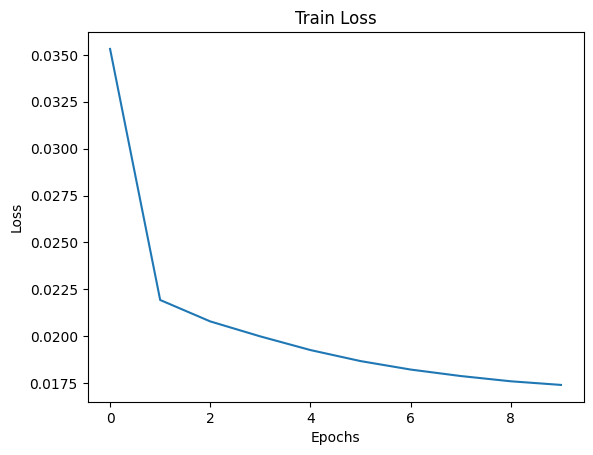

In [ ]:
# net = Autoencoder()
device = get_device()
print(device)
model.to(device)
DAE_make_dir()
train_loss = train(model, trainloader, epoch_num)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('DAE_conv_ae_cifar10_loss.png')
test(model, testloader)